<a href="https://colab.research.google.com/github/conwayjw97/ImageColourizationModels/blob/master/src/DeterministicConvNetCelebFaces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Global Variables

In [0]:
# For the flower images, half of these will be used for training, the other half for validation
IMAGE_COUNT = 1000

# These are starting indices, there will be 8 images shown in total
TRAINING_IMAGE = 0
TEST_IMAGE = 0

BATCH_SIZE = 10
EPOCHS = 100

# Import Statements

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import tensorflow_datasets as tfds
import datetime, os
import matplotlib.pyplot as plt
import numpy as np
import glob
import skimage
from skimage.transform import resize
from scipy.ndimage.filters import gaussian_filter1d
from tensorflow.keras import datasets, layers, models, backend

TensorFlow 2.x selected.


# Load Images

In [0]:
# This repository uses a handy cropped celebrity dataset
!git clone https://github.com/2014mchidamb/DeepColorization/

images = train_images = test_images = []
for image in skimage.io.imread_collection('DeepColorization/face_images/*.jpg'): 
  images.append(resize(image, (400, 400)))
  
train_images = np.array(images)[0:-1:2,:,:,:IMAGE_COUNT]
test_images = np.array(images)[1::2,:,:,:IMAGE_COUNT]
print(np.max(train_images[0]))
print(np.max(test_images[0]))

Cloning into 'DeepColorization'...
remote: Enumerating objects: 765, done.
remote: Total 765 (delta 0), reused 0 (delta 0), pack-reused 765
Receiving objects: 100% (765/765), 8.44 MiB | 34.56 MiB/s, done.
Resolving deltas: 100% (4/4), done.
0.9604564705882331
0.6065098039215681


# Convert to YUV

In [0]:
# Outputs a tensor of the same shape as the images tensor, containing the YUV 
# value of the pixels. The output is only well defined if the value in images 
# are in [0,1].
#https://zhengtq.github.io/2018/12/27/tensorflow-disturb-yuv/

train_images = tf.image.rgb_to_yuv(train_images[:IMAGE_COUNT])
# train_images = tf.dtypes.cast((train_images * 255), tf.int64)
train_y = tf.expand_dims(train_images[:,:,:,0], 3)
train_uv = train_images[:,:,:,1:]

test_images = tf.image.rgb_to_yuv(test_images[:IMAGE_COUNT])
# test_images = tf.dtypes.cast((test_images * 255), tf.int64)
test_y = tf.expand_dims(test_images[:,:,:,0], 3)
test_uv = test_images[:,:,:,1:]

print(train_images[0])

tf.Tensor(
[[[ 2.35680375e-01 -5.87802386e-02  1.10454761e-01]
  [ 2.36612340e-01 -5.73862159e-02  1.11112375e-01]
  [ 2.35796871e-01 -5.86059858e-02  1.10536962e-01]
  ...
  [ 8.57050902e-02 -1.37536303e-02  3.82880771e-02]
  [ 8.64899027e-02 -1.48747309e-02  3.98344098e-02]
  [ 8.55929741e-02 -1.35934730e-02  3.80671724e-02]]

 [[ 2.37062850e-01 -5.88430189e-02  1.10717150e-01]
  [ 2.37874747e-01 -5.73899089e-02  1.11127809e-01]
  [ 2.37164337e-01 -5.86613801e-02  1.10768483e-01]
  ...
  [ 8.44756627e-02 -1.26545746e-02  3.65042821e-02]
  [ 8.66621004e-02 -1.37737732e-02  3.74374993e-02]
  [ 8.41633145e-02 -1.24946891e-02  3.63709654e-02]]

 [[ 2.35853184e-01 -5.87880862e-02  1.10487559e-01]
  [ 2.36770141e-01 -5.73866775e-02  1.11114304e-01]
  [ 2.35967804e-01 -5.86129101e-02  1.10565902e-01]
  ...
  [ 8.55514118e-02 -1.36162483e-02  3.80651027e-02]
  [ 8.65114275e-02 -1.47371112e-02  3.95347960e-02]
  [ 8.54142667e-02 -1.34561250e-02  3.78551466e-02]]

 ...

 [[ 2.68814980e-01 -3.4

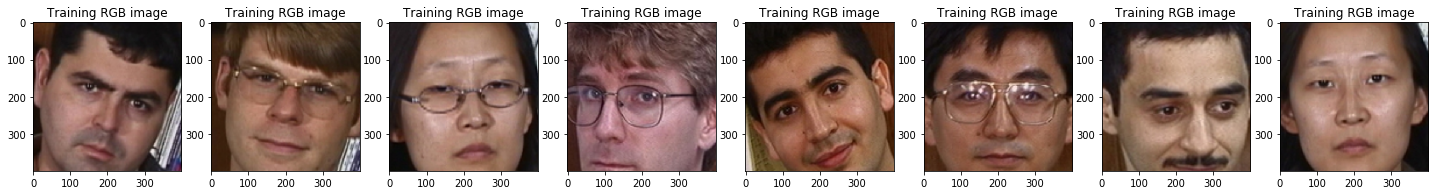

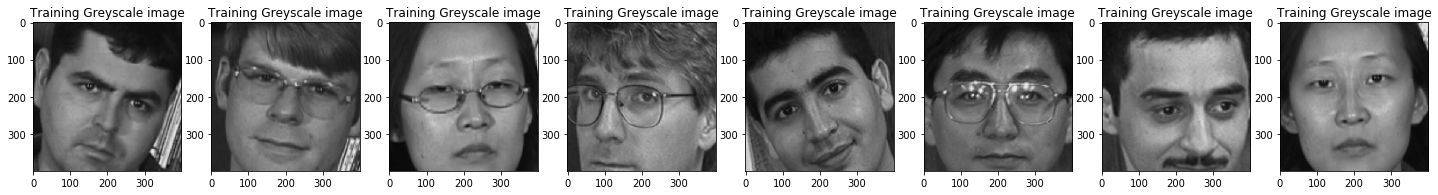

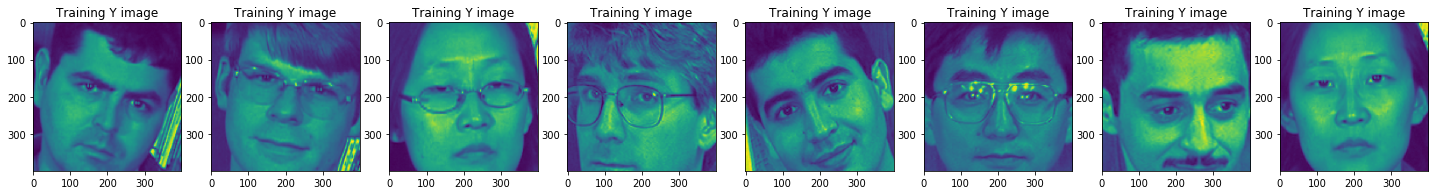

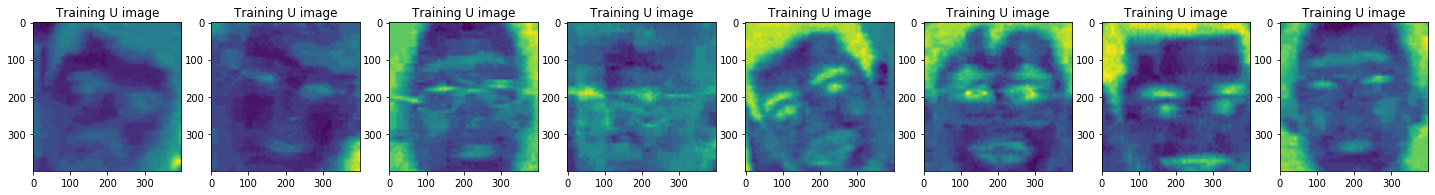

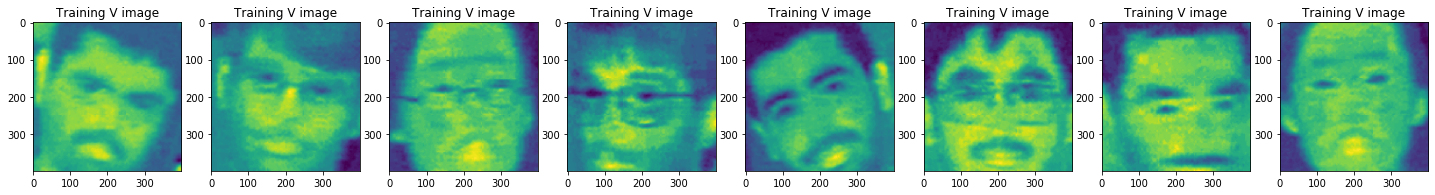

In [0]:
fig = plt.figure(figsize=(25, 16))
for i in range(8):
  fig.add_subplot(1,8,i+1)
  plt.title("Training RGB image")
  plt.imshow(tf.image.yuv_to_rgb(train_images[TRAINING_IMAGE+i]))

fig = plt.figure(figsize=(25, 16))
for i in range(8):
  fig.add_subplot(1,8,i+1)
  plt.title("Training Greyscale image")
  plt.imshow((tf.image.grayscale_to_rgb(train_y[TRAINING_IMAGE+i])))

fig = plt.figure(figsize=(25, 16))
for i in range(8):
  fig.add_subplot(1,8,i+1)
  plt.title("Training Y image")
  plt.imshow(train_images[TRAINING_IMAGE+i,:,:,0])
  
fig = plt.figure(figsize=(25, 16))
for i in range(8):
  fig.add_subplot(1,8,i+1)
  plt.title("Training U image")
  plt.imshow(train_images[TRAINING_IMAGE+i,:,:,1])
  
fig = plt.figure(figsize=(25, 16))
for i in range(8):
  fig.add_subplot(1,8,i+1)
  plt.title("Training V image")
  plt.imshow(train_images[TRAINING_IMAGE+i,:,:,2])

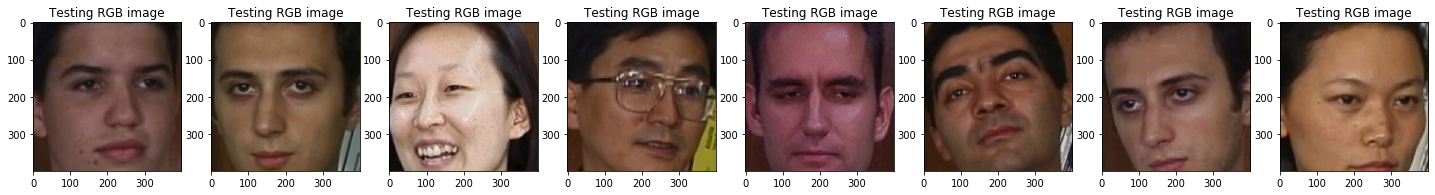

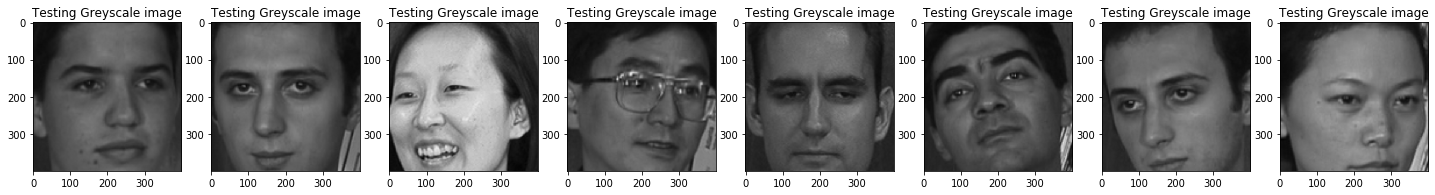

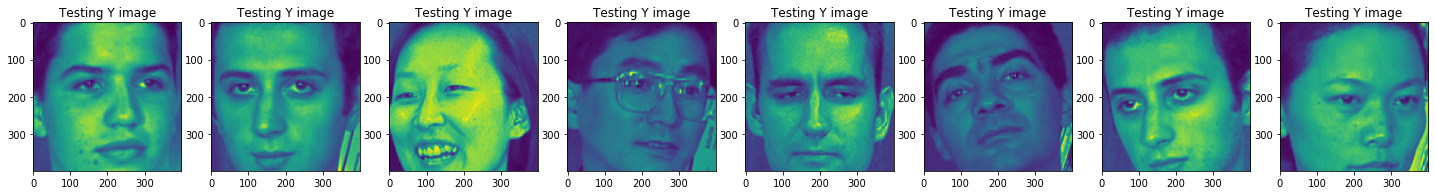

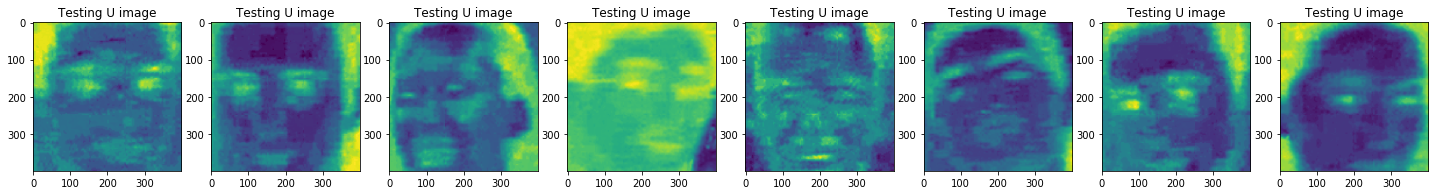

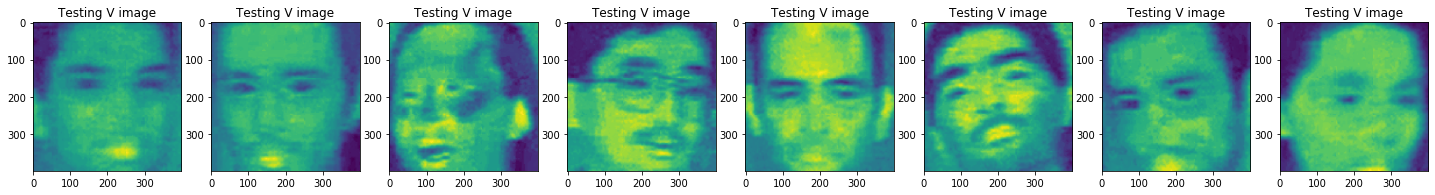

In [0]:
fig = plt.figure(figsize=(25, 16))
for i in range(8):
  fig.add_subplot(1,8,i+1)
  plt.title("Testing RGB image")
  plt.imshow(tf.image.yuv_to_rgb(test_images[TRAINING_IMAGE+i]))

fig = plt.figure(figsize=(25, 16))
for i in range(8):
  fig.add_subplot(1,8,i+1)
  plt.title("Testing Greyscale image")
  plt.imshow(tf.image.grayscale_to_rgb(test_y[TEST_IMAGE+i]))

fig = plt.figure(figsize=(25, 16))
for i in range(8):
  fig.add_subplot(1,8,i+1)
  plt.title("Testing Y image")
  plt.imshow(test_images[TEST_IMAGE+i,:,:,0])
  
fig = plt.figure(figsize=(25, 16))
for i in range(8):
  fig.add_subplot(1,8,i+1)
  plt.title("Testing U image")
  plt.imshow(test_images[TEST_IMAGE+i,:,:,1])
  
fig = plt.figure(figsize=(25, 16))
for i in range(8):
  fig.add_subplot(1,8,i+1)
  plt.title("Testing V image")
  plt.imshow(test_images[TEST_IMAGE+i,:,:,2])

# Create the Convolutional Neural Network

In [0]:
# Conv2D(filters (number of output filters)
#           - determine parameter number
#        kernel_size (size of convolution window)
#        activation (activation function to use)
#        padding ("valid" or "same")
#        strides (strides of the convolution along the height and width)
#           - strides greater than 1 will downsample
#        input_shape (only used on the first layer of the model))
#
# UpSampling2D(size (upsampling factors for rows and columns))

#https://github.com/emilwallner/Coloring-greyscale-images

def create_model_shallow():
  model = models.Sequential()
  model.add(layers.Conv2D(64, (2, 2), activation='relu', input_shape=(train_uv.shape[1], train_uv.shape[2], 1)))
  model.add(layers.Conv2D(128, (2, 2), activation='relu', padding='same'))
  model.add(layers.Conv2D(128, (4, 4), activation='relu', padding='same', strides=2))
  model.add(layers.Conv2D(128, (4, 4), activation='relu', padding='same'))
  model.add(layers.Conv2D(64, (4, 4), activation='relu', padding='same'))
  model.add(layers.Conv2D(32, (4, 4), activation='relu', padding='same'))
  model.add(layers.UpSampling2D((2, 2)))
  model.add(layers.Conv2D(2, (4, 4), activation='tanh', padding='same'))
  return model

def create_model_mid():
  model = models.Sequential()
  model.add(layers.Conv2D(64, (4, 4), activation='relu', input_shape=(train_uv.shape[1], train_uv.shape[2], 1)))
  model.add(layers.Conv2D(64, (4, 4), activation='relu', padding='same', strides=2))
  model.add(layers.Conv2D(128, (4, 4), activation='relu', padding='same'))
  model.add(layers.Conv2D(128, (4, 4), activation='relu', padding='same', strides=2))
  model.add(layers.Conv2D(256, (4, 4), activation='relu', padding='same'))
  model.add(layers.Conv2D(256, (4, 4), activation='relu', padding='same'))
  model.add(layers.Conv2D(128, (4, 4), activation='relu', padding='same'))
  model.add(layers.Conv2D(64, (4, 4), activation='relu', padding='same'))
  model.add(layers.UpSampling2D((2, 2)))
  model.add(layers.Conv2D(32, (4, 4), activation='relu', padding='same'))
  model.add(layers.Conv2D(2, (4, 4), activation='tanh', padding='same'))
  model.add(layers.UpSampling2D((2, 2)))
  return model

def create_model_deep():
  model = models.Sequential()
  model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(train_uv.shape[1], train_uv.shape[2], 1)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
  model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
  model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
  model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
  model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
  model.add(layers.UpSampling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
  model.add(layers.UpSampling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(layers.UpSampling2D((2, 2)))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(layers.Conv2D(2, (3, 3), activation='tanh', padding='same'))
  return model

create_model_shallow().summary()
create_model_mid().summary()
create_model_deep().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 399, 399, 64)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 399, 399, 128)     32896     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 200, 200, 128)     262272    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 200, 200, 128)     262272    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 200, 200, 64)      131136    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 200, 200, 32)      32800     
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 400, 400, 32)      0

# Compile and Train the Model

In [0]:
# fit(x (input data)
#     y (target data)
#     batch_size (samples per gradient update)
#        - smaller batch size = more stochastic
#     epochs (epochs to train the model))

model = create_model_deep()
model.compile(optimizer='rmsprop',
              loss='mse')

runtime_epochs = int(EPOCHS/4)
total_loss = []
total_val_loss = []

history = model.fit(x=train_y, y=train_uv, validation_data=(test_y, test_uv), batch_size=BATCH_SIZE, epochs=runtime_epochs)
total_loss += history.history["loss"]
total_val_loss += history.history["val_loss"]

Train on 375 samples, validate on 375 samples
Epoch 1/25
375/375 [==============================] - 59s 157ms/sample - loss: 0.0287 - val_loss: 9.4195e-04
Epoch 2/25
375/375 [==============================] - 45s 120ms/sample - loss: 0.0037 - val_loss: 5.8489e-04
Epoch 3/25
375/375 [==============================] - 45s 120ms/sample - loss: 6.9532e-04 - val_loss: 4.4314e-04
Epoch 4/25
375/375 [==============================] - 45s 120ms/sample - loss: 8.3049e-04 - val_loss: 4.8216e-04
Epoch 5/25
375/375 [==============================] - 45s 120ms/sample - loss: 6.1694e-04 - val_loss: 0.0010
Epoch 6/25
375/375 [==============================] - 45s 120ms/sample - loss: 6.2669e-04 - val_loss: 4.6990e-04
Epoch 7/25
375/375 [==============================] - 45s 120ms/sample - loss: 5.9427e-04 - val_loss: 4.9153e-04
Epoch 8/25
375/375 [==============================] - 45s 120ms/sample - loss: 5.6793e-04 - val_loss: 3.8678e-04
Epoch 9/25
375/375 [==============================] - 45s 120m

In [0]:
history = model.fit(x=train_y, y=train_uv, validation_data=(test_y, test_uv), batch_size=BATCH_SIZE, epochs=runtime_epochs)
total_loss += history.history["loss"]
total_val_loss += history.history["val_loss"]

Train on 375 samples, validate on 375 samples
Epoch 1/25
375/375 [==============================] - 45s 120ms/sample - loss: 3.6955e-04 - val_loss: 4.3418e-04
Epoch 2/25
375/375 [==============================] - 45s 120ms/sample - loss: 3.7695e-04 - val_loss: 3.8262e-04
Epoch 3/25
375/375 [==============================] - 45s 120ms/sample - loss: 3.6632e-04 - val_loss: 3.6483e-04
Epoch 4/25
375/375 [==============================] - 45s 120ms/sample - loss: 3.7112e-04 - val_loss: 3.6773e-04
Epoch 5/25
375/375 [==============================] - 45s 120ms/sample - loss: 3.7403e-04 - val_loss: 3.1309e-04
Epoch 6/25
375/375 [==============================] - 45s 120ms/sample - loss: 3.5579e-04 - val_loss: 4.9172e-04
Epoch 7/25
375/375 [==============================] - 45s 120ms/sample - loss: 3.5893e-04 - val_loss: 3.9361e-04
Epoch 8/25
375/375 [==============================] - 45s 120ms/sample - loss: 3.5052e-04 - val_loss: 4.1623e-04
Epoch 9/25
375/375 [==============================

In [0]:
history = model.fit(x=train_y, y=train_uv, validation_data=(test_y, test_uv), batch_size=BATCH_SIZE, epochs=runtime_epochs)
total_loss += history.history["loss"]
total_val_loss += history.history["val_loss"]

Train on 375 samples, validate on 375 samples
Epoch 1/25
375/375 [==============================] - 45s 120ms/sample - loss: 2.9657e-04 - val_loss: 4.1027e-04
Epoch 2/25
375/375 [==============================] - 45s 120ms/sample - loss: 3.0639e-04 - val_loss: 3.1899e-04
Epoch 3/25
375/375 [==============================] - 45s 120ms/sample - loss: 2.8478e-04 - val_loss: 2.8276e-04
Epoch 4/25
375/375 [==============================] - 45s 120ms/sample - loss: 2.8666e-04 - val_loss: 3.0389e-04
Epoch 5/25
375/375 [==============================] - 45s 120ms/sample - loss: 2.7546e-04 - val_loss: 2.8851e-04
Epoch 6/25
375/375 [==============================] - 45s 120ms/sample - loss: 2.8010e-04 - val_loss: 4.1561e-04
Epoch 7/25
375/375 [==============================] - 45s 120ms/sample - loss: 2.8795e-04 - val_loss: 2.9874e-04
Epoch 8/25
375/375 [==============================] - 45s 120ms/sample - loss: 2.7064e-04 - val_loss: 2.8011e-04
Epoch 9/25
375/375 [==============================

In [0]:
history = model.fit(x=train_y, y=train_uv, validation_data=(test_y, test_uv), batch_size=BATCH_SIZE, epochs=runtime_epochs)
total_loss += history.history["loss"]
total_val_loss += history.history["val_loss"]

Train on 375 samples, validate on 375 samples
Epoch 1/25
375/375 [==============================] - 45s 120ms/sample - loss: 2.2073e-04 - val_loss: 2.7580e-04
Epoch 2/25
375/375 [==============================] - 45s 120ms/sample - loss: 2.3041e-04 - val_loss: 2.5852e-04
Epoch 3/25
375/375 [==============================] - 45s 120ms/sample - loss: 2.2654e-04 - val_loss: 2.6360e-04
Epoch 4/25
375/375 [==============================] - 45s 120ms/sample - loss: 2.2174e-04 - val_loss: 2.7227e-04
Epoch 5/25
375/375 [==============================] - 45s 120ms/sample - loss: 2.1843e-04 - val_loss: 3.1688e-04
Epoch 6/25
375/375 [==============================] - 45s 120ms/sample - loss: 2.1427e-04 - val_loss: 3.8829e-04
Epoch 7/25
375/375 [==============================] - 45s 120ms/sample - loss: 2.2332e-04 - val_loss: 2.6510e-04
Epoch 8/25
375/375 [==============================] - 45s 120ms/sample - loss: 2.1294e-04 - val_loss: 2.6233e-04
Epoch 9/25
375/375 [==============================

# Loss Function Results

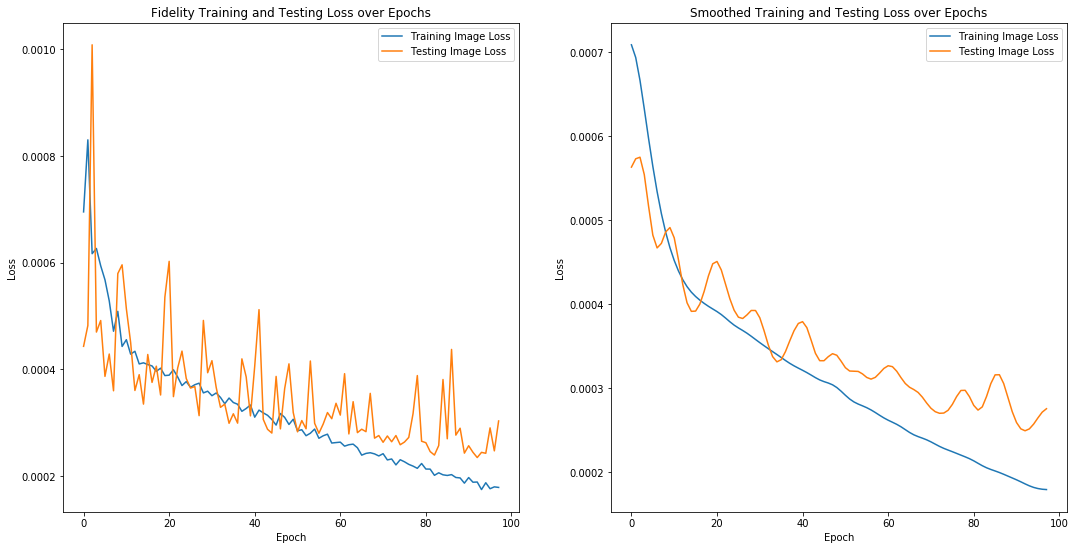

In [0]:
fig = plt.figure(figsize=(18, 9))
fig.add_subplot(1,2,1)
plt.title("Fidelity Training and Testing Loss over Epochs")
plt.plot(total_loss[2:], label="Training Image Loss")
plt.plot(total_val_loss[2:], label="Testing Image Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
fig.add_subplot(1,2,2)
plt.title("Smoothed Training and Testing Loss over Epochs")
plt.plot(gaussian_filter1d(total_loss[2:], sigma=2), label="Training Image Loss")
plt.plot(gaussian_filter1d(total_val_loss[2:], sigma=2), label="Testing Image Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Training Results

375/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


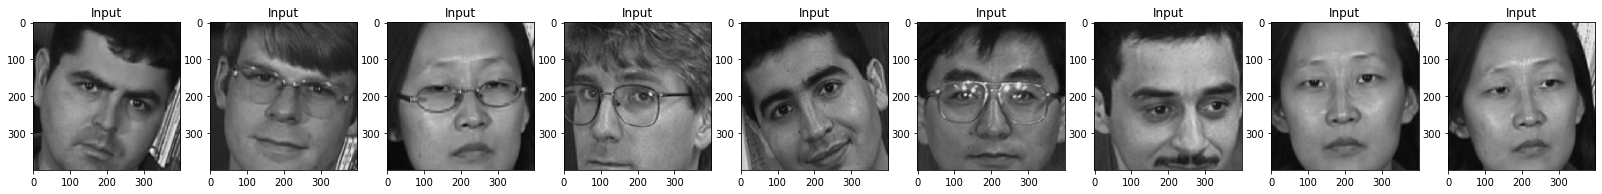

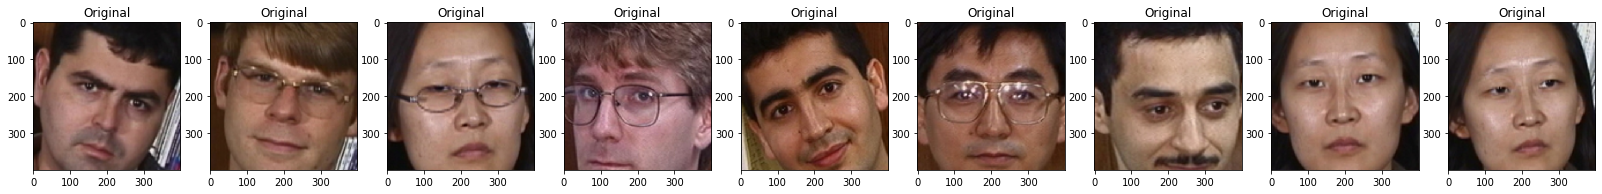

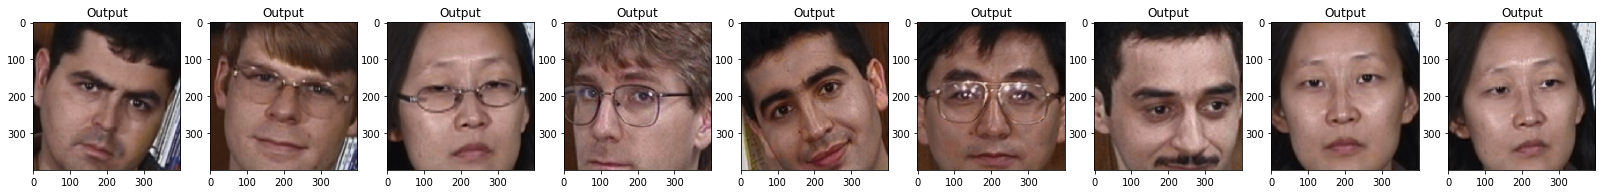

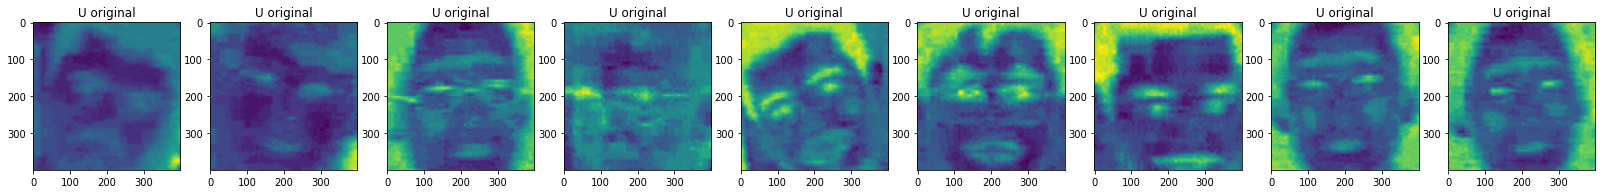

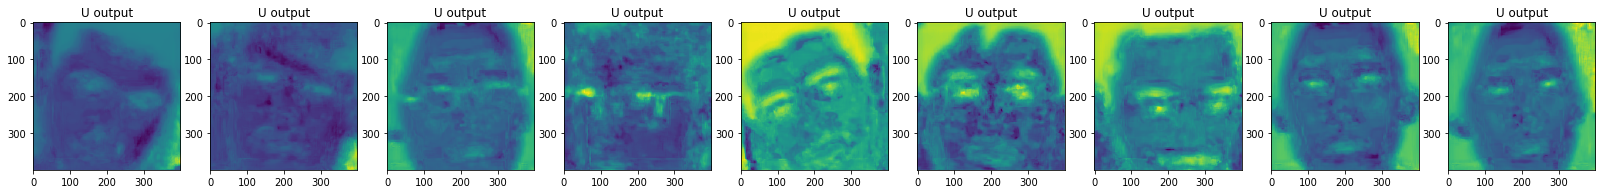

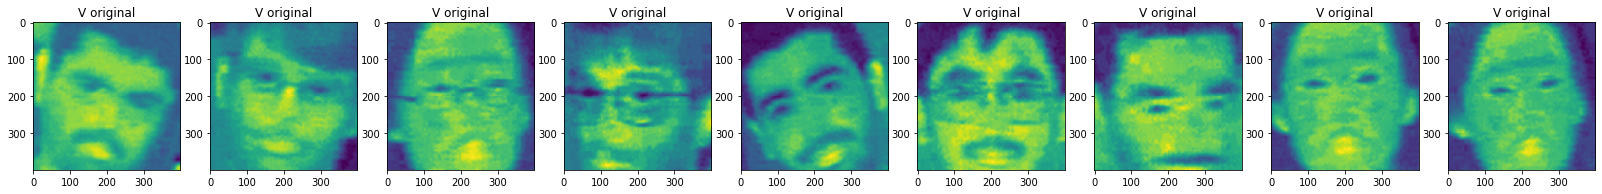

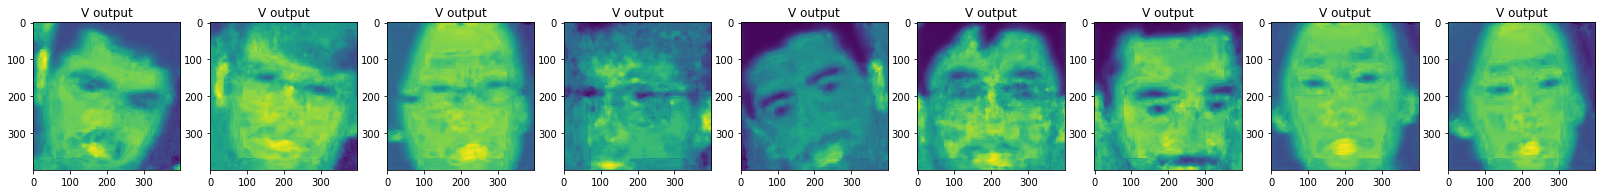

In [0]:
print(model.evaluate(train_y, train_uv, batch_size=BATCH_SIZE))
output = model.predict(train_y)
result = np.zeros((train_y.shape[0], train_y.shape[1], train_y.shape[2], 3))
result[:,:,:,0] = train_y[:,:,:,0]
result[:,:,:,1:] = output

output_count = 9

fig = plt.figure(figsize=(28, 16))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Input")
  plt.imshow(tf.image.grayscale_to_rgb(train_y[TRAINING_IMAGE+i]))

fig = plt.figure(figsize=(28, 16))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Original")
  plt.imshow(tf.image.yuv_to_rgb(train_images[TRAINING_IMAGE+i]))

fig = plt.figure(figsize=(28, 16))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Output")
  plt.imshow(tf.image.yuv_to_rgb(result[TRAINING_IMAGE+i]))
  
fig = plt.figure(figsize=(28, 16))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("U original")
  plt.imshow(train_images[TRAINING_IMAGE+i,:,:,1])
  
fig = plt.figure(figsize=(28, 16))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("U output")
  plt.imshow(result[TRAINING_IMAGE+i,:,:,1])
  
fig = plt.figure(figsize=(28, 16))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("V original")
  plt.imshow(train_images[TRAINING_IMAGE+i,:,:,2])
  
fig = plt.figure(figsize=(28, 16))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("V output")
  plt.imshow(result[TRAINING_IMAGE+i,:,:,2])

# Testing Results

375/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


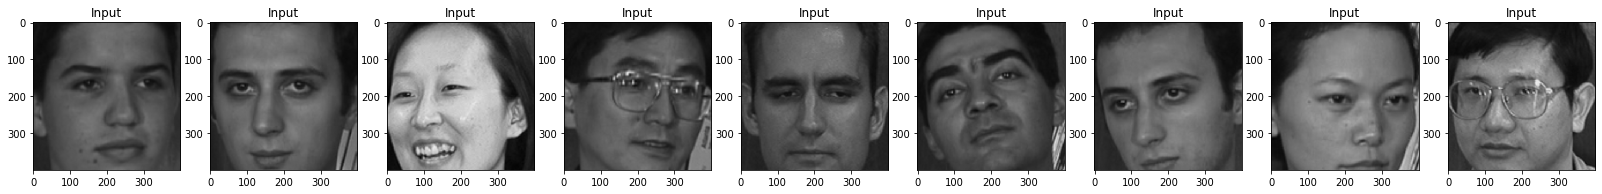

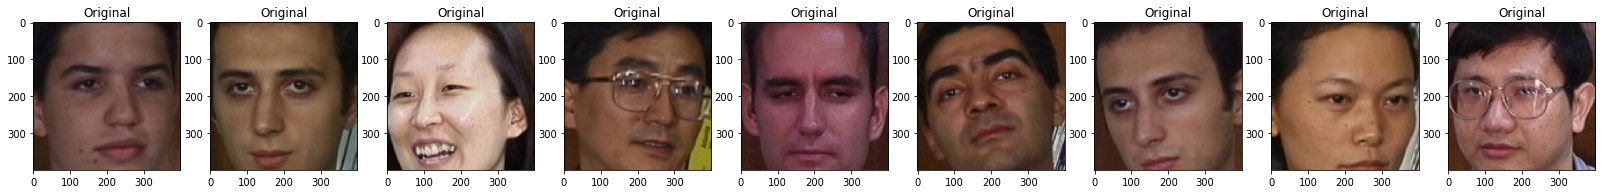

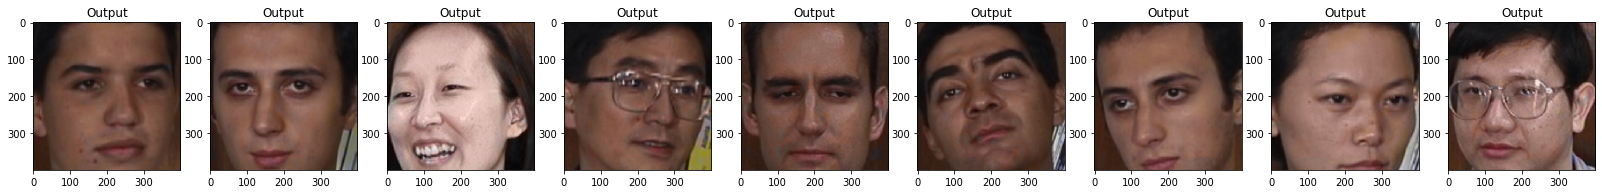

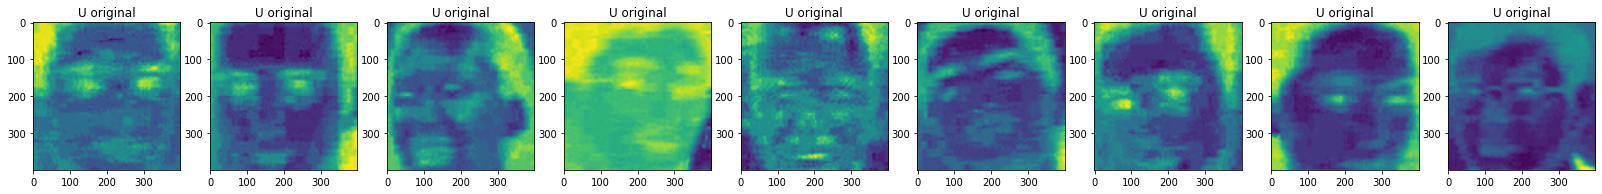

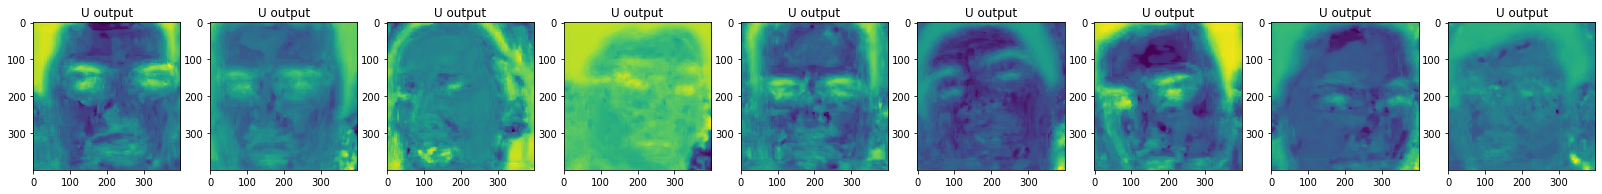

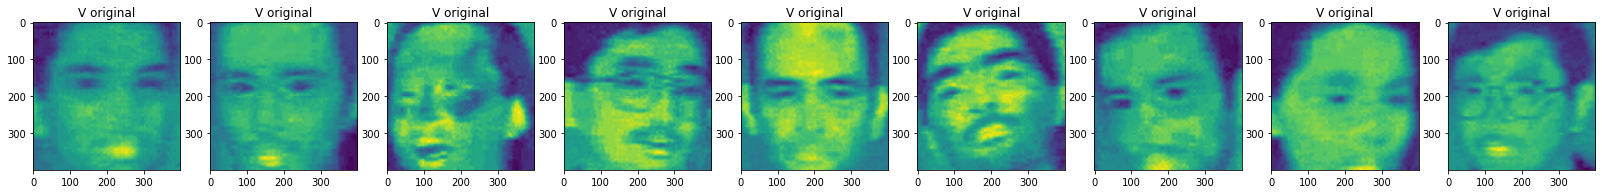

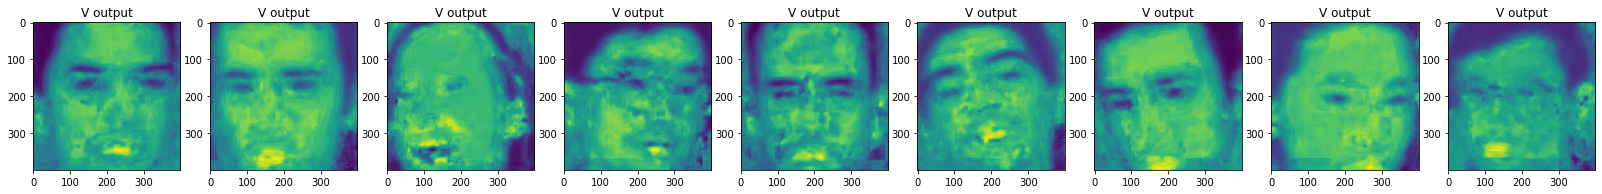

In [0]:
print(model.evaluate(test_y, test_uv, batch_size=BATCH_SIZE))
output = model.predict(test_y)
result = np.zeros((train_y.shape[0], train_y.shape[1], train_y.shape[2], 3))
result[:,:,:,0] = test_y[:,:,:,0]
result[:,:,:,1:] = output
  
output_count = 9

fig = plt.figure(figsize=(28, 16))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Input")
  plt.imshow(tf.image.grayscale_to_rgb(test_y[TEST_IMAGE+i]))

fig = plt.figure(figsize=(28, 16))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Original")
  plt.imshow(tf.image.yuv_to_rgb(test_images[TEST_IMAGE+i]))

fig = plt.figure(figsize=(28, 16))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Output")
  plt.imshow(tf.image.yuv_to_rgb(result[TEST_IMAGE+i]))
  
fig = plt.figure(figsize=(28, 16))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("U original")
  plt.imshow(test_images[TEST_IMAGE+i,:,:,1])
  
fig = plt.figure(figsize=(28, 16))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("U output")
  plt.imshow(result[TEST_IMAGE+i,:,:,1])
  
fig = plt.figure(figsize=(28, 16))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("V original")
  plt.imshow(test_images[TEST_IMAGE+i,:,:,2])
  
fig = plt.figure(figsize=(28, 16))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("V output")
  plt.imshow(result[TEST_IMAGE+i,:,:,2])